# California Wildfires: Prediction and Prevention
### 1. Akshay Bhide (A14437176) and Peter Larcheveque (A15588430)

## 2. Questions and Significance
The question we address in this project is: What factors contribute to California wildfires, and can we analyze these factors before an incident to find high risk areas for wildfires and take the necessary precautions?

The business case for the above proposed questions is its relevance to state and federal authorities due to the damaging nature of wildfires. At a state level, the governor is responsible for the safety and well-being of his/her people, so it is of obvious importance in that sense. At a federal level, they are also concerned for the well-being of their citizens, and are additionally concerned with the well being of natural parks. If we are able to accurately predict wildfires, we can then allocate resources to particular underserviced areas and mitigate the damage of many wildfires before they get out of control. There are also major financial implications in regards to wildfires. According to a Stanford climate policy researcher Michael Wara, Ph.D., California spends about 2.5 billion dollars annually on fighting wildfires, so being better prepared to handle future wildfires will allow California to be better off fiscally. With the more recent devastating California wildfires, experts peg the estimated damages at close to 10 billion dollars. These numbers are only estimating the direct damage costs. Indirect costs include but are not limited to health care bills, costs of disrupted businesses, lost tax revenue, decreased property values, and the fleeing/evacuation of areas due to smoke or wildfires. There are a multitude of different reasons (ethical, financial) why being able to predict wildfires is beneficial.

## 3. Background and Literature

Overall, we used information from these sources to inform some of the decisions we made in regards to our problem statement, business use cases, and analytic strategy.

- https://www.nytimes.com/2020/09/16/us/california-fires-cost.html - September 2020 article that provides insights into the costs of these Californian Wildfires. Mostly addresses financial implications of wildfires in CA.


- https://www.fs.usda.gov/treesearch/pubs/29070 - Addresses various factors that exacerbate wildfires. Also goes into detail about computer models that forecast how a current wildfire will brun (this is slightly different from our own investigation); talks about how these forecasting programs make recommendations to land managers, specifically about the idea of thinning dorests where fires will burn. Note that this paper was published in 2007, so it's not very up to date.


- https://news.stanford.edu/2020/09/22/predicting-wildfires-cat-scans/ - Stanford research that looks into the process of smoldering through the use of CAT scans; smoldering is the starte of burning without flame that often leads to fires; they use this deeper understanding of smoldering in their model to predict where wildfires will strike next.


- https://github.com/IBM/predict-wildfire-intensity - GitHub project that uses IBM's Watson Machine Learning Platform to predict intensity of wildfires based on latitude and longitude; utilizes NASA wildfire data


- https://github.com/SKhatter/Analyzing-and-Predicting-Wildfires - Predicts occurrences of wildfires using maching learning and ArcGIS. Utilizes data from the San Diego region specifically.

- https://www.redzone.co/2017/09/20/wildfire-risk-five-areas/#:~:text=Typically%2C%20wildfires%20burn%20up%20a,a%20wildfire%2C%20enhancing%20wildfire%20risk. - Provides insight into how slope affects wildfire risk, this was especially important in coming up with weights during weighting and rating

- https://www.auburn.edu/academic/forestry_wildlife/fire/weather_elements.htm - Addresses wildfire risk in relation to many weather attributes (wind, temperature, precipitation, humidity). We primarily used this source to inform us about the effect of temperature and humidity on wildfire risk. This helped narrow down which rasters to focus on attaining and working with

## Python Libraries and ArcGIS Modules


Python Libraries:
- Numpy: Used to access np.NaN (correlation analysis)
- Pandas: Used for spatially-enabled dataframe manipulation/analysis
- Pyplot: Used to visualize distributions for certain variables/features
- PearsonR: Used to find correlation coefficients for suitability model correlation analysis

ArcGIS Modules

- geometry: Used when creating raster study area geometry, so we can visualize and analyze our rasters in the context of our study area (California)
- features: Used when publishing/accessing feature layers on ArcGIS Online
- geocoding: Used to geocode California for finding the extent for our rasters
- raster: Used to import raster functions that are used in our various raster analyses and the construction of our suitability model

This list is mostly in-line with the list we envisioned in our project proposal. One note is that we have not included geoenrichment in this report because it did not give us the information we were looking for, and instead relied on outside research to inform us about what land and weather attributes contribute to wildfires.

In [131]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import pearsonr

import arcgis
from arcgis.gis import GIS
from arcgis import geometry
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.features import FeatureLayerCollection
from arcgis.geocoding import geocode
from arcgis.raster.functions import *
from arcgis.geoenrichment import *
import libpysal as lps
from libpysal.weights import Queen
import geopandas as gpd
import esda
from splot.esda import plot_moran
from arcgis.features import use_proximity
from IPython.display import Image
import warnings


#queen - contiguity weights
#libpysal - used for weights
#esda - exploratory spatial data analysis
# contiguous attr - shape areas

In [132]:
warnings.filterwarnings('ignore')

## 5. Data Sources


- https://ucsdonline.maps.arcgis.com/home/item.html?id=6fd0d8d6f47d414da7bcb1dcd0539999 - A dataset of California fire perimeteres from 1878 to 2019 (~20,000 records)
- https://landscape3.arcgis.com/arcgis/rest/services/USA_Mean_Rainfall/ImageServer - Raster providing information about mean rainfall
- https://landscape3.arcgis.com/arcgis/rest/services/USA_Woody_Biomass/ImageServer - Raster providing information about woody biomass
- https://landscape3.arcgis.com/arcgis/rest/services/USA_Mean_Temperature/ImageServer - Raster providing information about mean temperature
- https://landscape3.arcgis.com/arcgis/rest/services/Landscape_Modeler/USA_Slope/ImageServer - Raster providing information about topography slope
- https://ucsdonline.maps.arcgis.com/home/item.html?id=99fd67933e754a1181cc755146be21ca - Dataset used to get geometry of California

A lot of sources that we proposed in our project proposal involved data from organizations like NASA that would have been relatively difficult to obtain and clean, and would contain much more information than we would have needed. Therefore, we chose to use rasters that we didn't previously consider using as our primary data sources for things like weather and slope. One thing to note is that we did have a lot of trouble getting a wind raster to work. We were able to successfully get the shapefile for the windraster, but we could not convert the shapefile to a raster due to complications and issues with ArcPy's compatibility.

In [4]:
# establish ArcGIS connection
# gis=GIS(username='USERNAME_HERE')
gis=GIS(username='plarchev_dsc170fa20') 

Enter password: ········


In [5]:
# code cell, importing all data sources 
fires = gis.content.get('6fd0d8d6f47d414da7bcb1dcd0539999')
# the second layer is the one we want (burn areas)
lyr = fires.layers[1]
# get spatially-enabled dataframe
df = lyr.query().sdf

In [130]:
# firestations layer 
firestations = gis.content.get('9e83fab7fe924a4986dd978bf354db94').layers[0]
# query, convert to sedf
firestations = firestations.query().sdf
# get firestations only in cali
firestations = firestations[firestations.STATE == 'CA']
firestations.head()

FID  FID_1  OBJECTID                              PERMANENT_  \
2475  2476   2874      3257  {888ACA39-FEDD-480E-BC7B-DACEC5E5115F}   
2476  2477   2875      3258  {AFDFF2AC-4801-492A-929A-5FE7DEDC61CC}   
2492  2493   2891      3274  {8D397EFD-9FB3-401C-B8F1-167133B018A0}   
2493  2494   2892      3275  {566CA87C-8A68-43C6-A750-78851CEDB02F}   
3466  3467   2657      2645  {F07E224D-D5D6-44DD-B2CA-5ADB414673DD}   

     SOURCE_FEA                            SOURCE_DAT  \
2475   10508259  a67e37d3-ede5-4ae1-a9ab-3f76094db6ae   
2476   10511708  a67e37d3-ede5-4ae1-a9ab-3f76094db6ae   
2492   10521421  a67e37d3-ede5-4ae1-a9ab-3f76094db6ae   
2493   10511705  34446b40-b867-485c-b56d-51c1998e8bb7   
3466   10522666  a9fde8f0-4665-4fb0-a41e-c142025bd57e   

                               SOURCE_D_1  \
2475  730 TNMC Update 09/21/2016 15:05:47   
2476  730 TNMC Update 09/21/2016 15:05:47   
2492  730 TNMC Update 09/21/2016 15:05:47   
2493  740 TNMC Update 09/21/2016 16:40:17   
3466  740 TNMC Update 10/18/2016 09:22:28   

                                             SOURCE_ORI  DATA_SECUR  \
2475  Oak Ridge National Laboratory, Geographic Info...           5   
2476  Oak Ridge National Laboratory, Geographic Info...           5   
2492  Oak Ridge National Laboratory, Geographic Info...           5   
2493                             U.S. Geological Survey           5   
3466                             U.S. Geological Survey           5   

     DISTRIBUTI  ... ADDRESSBUI                 ADDRESS          CITY STATE  \
2475         E4  ...                   300 Edmonds Road  Redwood City    CA   
2476         E4  ...              3700 Jefferson Avenue  Redwood City    CA   
2492         E4  ...              4091 Jefferson Avenue  Redwood City    CA   
2493         E4  ...              2190 Jefferson Avenue  Redwood City    CA   
3466         E4  ...             606 West Bonita Avenue     Claremont    CA   

      ZIPCODE  GNIS_ID  FOOT_ID COMPLEX_ID  \
2475    94062  2624230                       
2476    94062  2107887                       
2492    94062  2623899                       
2493    94061  2107889                       
3466    91711  2105685                       

                                    GLOBALID  \
2475  {E5A4692E-89B0-4FA0-A34A-9BA33634948F}   
2476  {F86023EA-D53B-4F5A-96AD-74E4626F18CE}   
2492  {B4C28B3F-8450-4F48-8A80-5A05F02AC7A4}   
2493  {8EB1824C-3C55-4AF5-BD70-4CCBA0934B96}   
3466  {9209D351-33A2-4234-9E5D-DB6939BA1D24}   

                                                  SHAPE  
2475  {"x": -13612817.2963, "y": 4505250.464599997, ...  
2476  {"x": -13609264.673, "y": 4504163.800499998, "...  
2492  {"x": -13610714.4286, "y": 4503049.966200002, ...  
2493  {"x": -13607628.0714, "y": 4505512.650700003, ...  
3466  {"x": -13104928.9139, "y": 4041727.0449, "spat...  

[5 rows x 27 columns]

In [6]:
# dimensions of fires dataset and example of what data the dataframe has
print(df.shape)
df.head(2)

(20820, 20)


OBJECTID YEAR_ STATE AGENCY UNIT_ID FIRE_NAME   INC_NUM  \
0         1  2007    CA    CCO     LAC   OCTOBER  00246393   
1         2  2007    CA    CCO     LAC     MAGIC  00233077   

                  ALARM_DATE                  CONT_DATE  CAUSE COMMENTS  \
0 1970-01-01 00:19:52.924800 1970-01-01 00:19:53.097600   14.0            
1 1970-01-01 00:19:53.011200 1970-01-01 00:19:53.270400   14.0            

   REPORT_AC   GIS_ACRES  C_METHOD  OBJECTIVE  FIRE_NUM   Shape__Area  \
0        NaN    25.73671       8.0        1.0  00233414  1.041528e+05   
1        NaN  2824.87700       8.0        1.0  00233077  1.143187e+07   

   Shape__Length                              GlobalID  \
0    1902.439051  691d7ef6-844e-499b-8426-d4be9f864819   
1   20407.965662  653105d7-b564-4979-99be-9bc1b8aa050e   

                                               SHAPE  
0  {"rings": [[[138036.905699998, -402646.3633], ...  
1  {"rings": [[[130072.487399999, -398622.8415], ...

In [7]:
# importing all rasters
usa_mean_rainfall = ImageryLayer("https://landscape3.arcgis.com/arcgis/rest/services/USA_Mean_Rainfall/ImageServer", gis) 
usa_woody_biomass = ImageryLayer('https://landscape3.arcgis.com/arcgis/rest/services/USA_Woody_Biomass/ImageServer', gis)
usa_mean_temperature = ImageryLayer("https://landscape3.arcgis.com/arcgis/rest/services/USA_Mean_Temperature/ImageServer", gis)
usa_slope = ImageryLayer("https://landscape3.arcgis.com/arcgis/rest/services/Landscape_Modeler/USA_Slope/ImageServer", gis)

## 6. Data Cleaning/Wrangling 
- finding ca extent and geometry, clipping rasters


First, we obtain extent and geometry information on California by examining AGOL layers as well as using geocoding. In terms of cleaning our rasters, since we were using rasters that were used in lecture, we had no cleaning to do. Therefore, this section also contains the clipping of our rasters, which puts them into the context we need them to be to start our analysis.

### Establishing California Geometries and Clipping Rasters

In [8]:
# get states content from AGOL, get CA geometry from it
usa_states = gis.content.get('99fd67933e754a1181cc755146be21ca')
st = usa_states.layers[0].query().sdf
ca_geom = st[st.STATE_NAME=='California'].SHAPE.values[0]

In [9]:
# use geocoding to get information about CA in the right spatial reference
study_area_gcd = geocode(address='California', out_sr=usa_mean_rainfall.extent['spatialReference'])

# get the geographic extent of the study area
ca_extent = study_area_gcd[0]['extent']
ca_extent

{'xmin': -2528018.9893711954,
 'ymin': -841945.708877204,
 'xmax': -1434603.3339299036,
 'ymax': 482923.0297394041}

In [10]:
# clipping raasters around CA extent and geometry

# rain clip
usa_mean_rainfall.extent = ca_extent
rain_clip = clip(raster=usa_mean_rainfall, geometry=ca_geom)

# temp clip
usa_mean_temperature.extent = ca_extent
temp_clip = clip(raster=usa_mean_temperature, geometry=ca_geom)

# woody biomass clip
usa_woody_biomass.extent = ca_extent
biomass_clip = clip(raster = usa_woody_biomass, geometry = ca_geom)

# slope clip
usa_slope.extent = ca_extent
slope_clip = clip(raster=usa_slope, geometry=ca_geom)

## 7. Descriptive Statistics

Investigating autocorrelation is pertinent to this study because we can then understand whether wildfires happending is indicative of wildfires occurring near a particular wildfire in the future. In these descriptive statistics, we investigate autocorrelation in detail. See markdown cells in this section for thought process involved.

### Visualizing Previous CA Wildfires

In [11]:
firemap = gis.map('California')
firemap.add_layer(lyr)
firemap

MapView(layout=Layout(height='400px', width='100%'))

### Visualizing Rasters

In [12]:
rainmap = gis.map('California')
rainmap.legend = True
rainmap.add_layer(rain_clip)
rainmap

MapView(layout=Layout(height='400px', width='100%'), legend=True)

In [13]:
tempmap = gis.map('California')
tempmap.legend = True
tempmap.add_layer(temp_clip)
tempmap

MapView(layout=Layout(height='400px', width='100%'), legend=True)

In [14]:
biomap = gis.map('California')
biomap.legend = True
biomap.add_layer(biomass_clip)
biomap

MapView(layout=Layout(height='400px', width='100%'), legend=True)

In [15]:
slopemap = gis.map('California')
slopemap.legend = True
slopemap.add_layer(slope_clip)
slopemap

MapView(layout=Layout(height='400px', width='100%'), legend=True)

Here we want to test whether the wildfire shape area are autocorrelated between the historic wildfires.

In [16]:
# converting to df
df_geom = df.rename(columns = {'SHAPE': 'geometry'})
df_geom.head(3)

OBJECTID YEAR_ STATE AGENCY UNIT_ID FIRE_NAME   INC_NUM  \
0         1  2007    CA    CCO     LAC   OCTOBER  00246393   
1         2  2007    CA    CCO     LAC     MAGIC  00233077   
2         3  2007    CA    USF     ANF     RANCH  00000166   

                  ALARM_DATE                  CONT_DATE  CAUSE COMMENTS  \
0 1970-01-01 00:19:52.924800 1970-01-01 00:19:53.097600   14.0            
1 1970-01-01 00:19:53.011200 1970-01-01 00:19:53.270400   14.0            
2 1970-01-01 00:19:52.838400 1970-01-01 00:19:55.084800    2.0            

   REPORT_AC    GIS_ACRES  C_METHOD  OBJECTIVE  FIRE_NUM   Shape__Area  \
0        NaN     25.73671       8.0        1.0  00233414  1.041528e+05   
1        NaN   2824.87700       8.0        1.0  00233077  1.143187e+07   
2    54716.0  58410.34000       7.0        1.0  00000166  2.363782e+08   

   Shape__Length                              GlobalID  \
0    1902.439051  691d7ef6-844e-499b-8426-d4be9f864819   
1   20407.965662  653105d7-b564-4979-99be-9bc1b8aa050e   
2  169150.715690  e7de1512-7b56-45f4-81fe-d5ef63981fed   

                                            geometry  
0  {"rings": [[[138036.905699998, -402646.3633], ...  
1  {"rings": [[[130072.487399999, -398622.8415], ...  
2  {"rings": [[[114013.9736, -379231.7455], [1141...

In [17]:
# then to gdf
gpd_geom = gpd.GeoDataFrame(df_geom, crs="EPSG:4326")

We used queen contiguity weight because it reflects adjacency relationships, so we want to understand how historical fires are related to each other spatially.

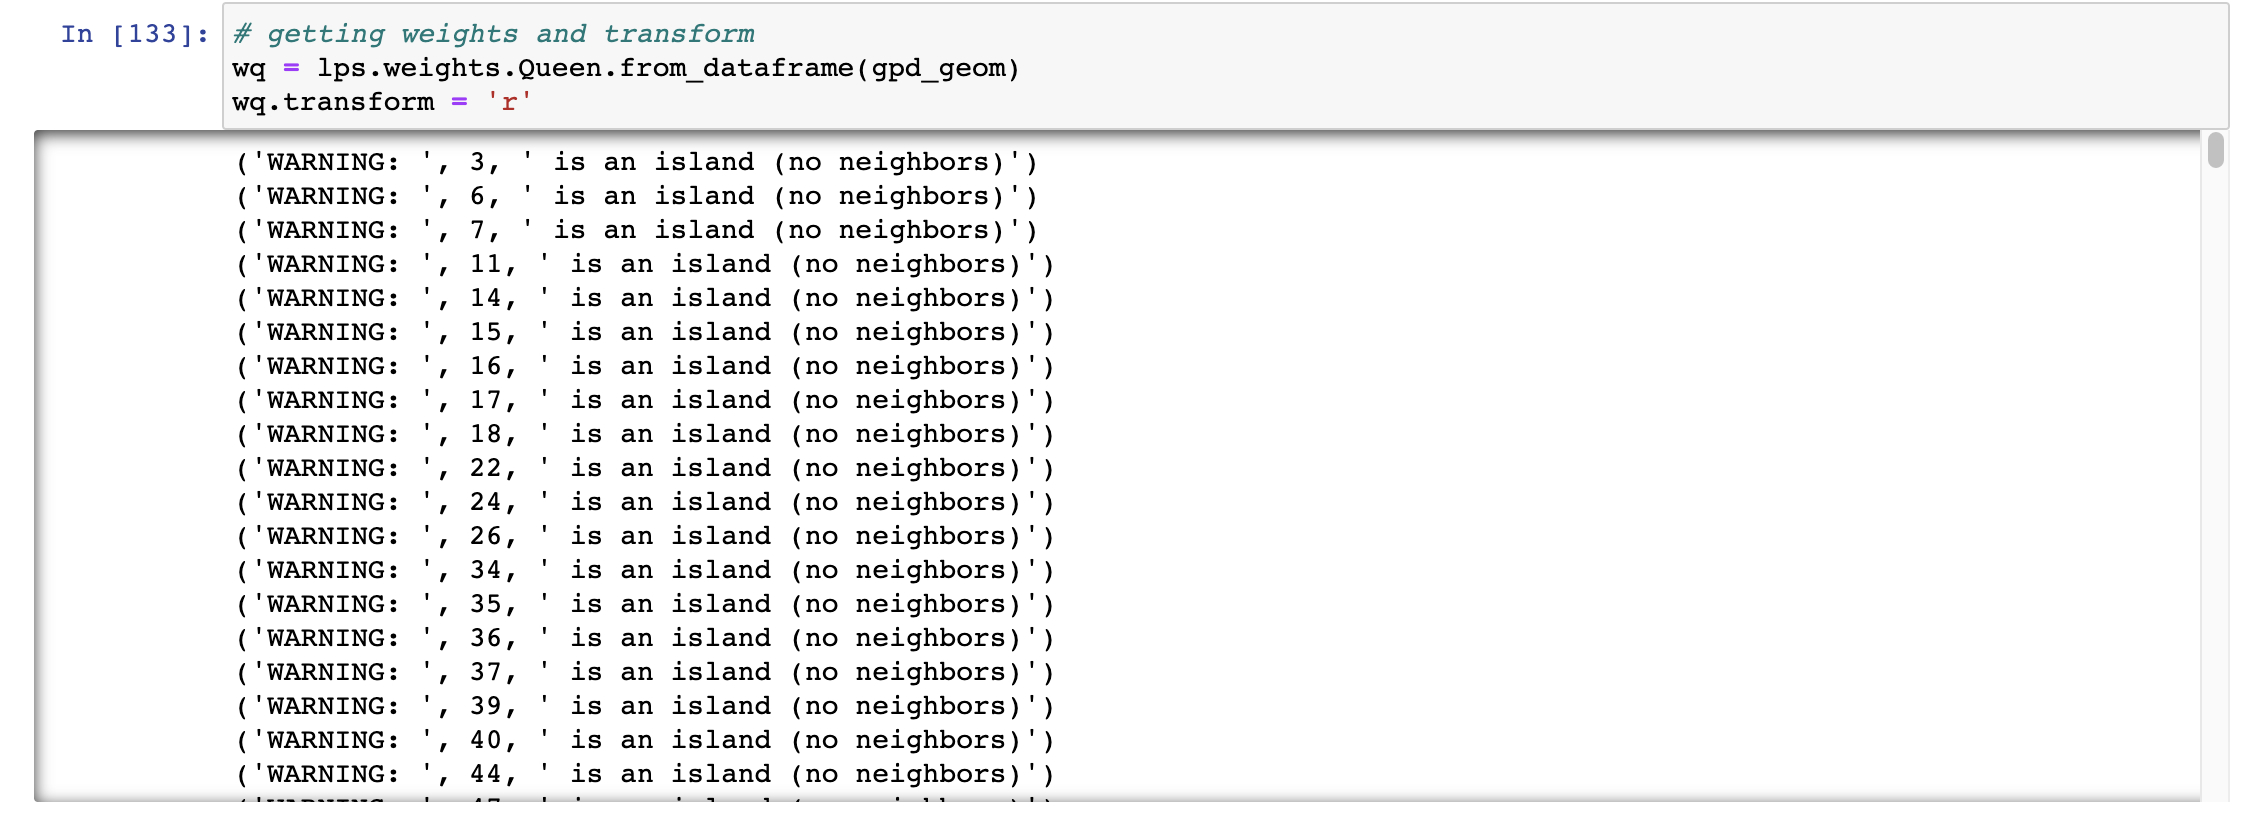

In [135]:
# Here we have an image of the cell that would have been here
# because it produces a ton of warning messages we cannot mute and makes our pdf 200 pages otherwise
Image('HEREHERE3.png', width = 800, height = 800)

In [ ]:
# this cell was producing a ton of warning messages
#wq = lps.weights.Queen.from_dataframe(gpd_geom)
#wq.transform = 'r'

In [19]:
# what we are checking the autocorrelation between
y = gpd_geom['Shape__Area']

Moran's I is a test for global autocorrelation for a continuous attribute.

In [20]:
# random seed and test for global autocorrelation using Moran's I
np.random.seed(12345)
mi = esda.moran.Moran(y, wq)
mi.I

0.1318896725756637

On the left, we have the reference distribution versus the observed statistic; on the right, we have a plot of the focal value against its spatial lag, for which the Moran I statistic serves as the slope

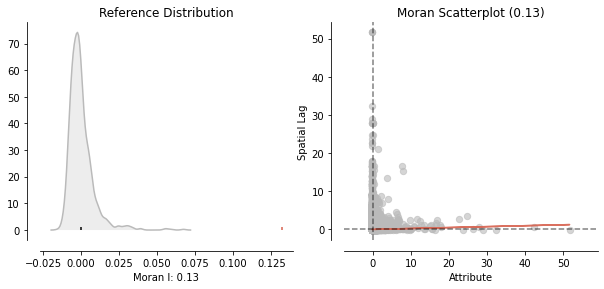

In [90]:
# plotting
plot_moran(mi, zstandard=True, figsize=(10,4))
plt.show()

In [91]:
# p-value
mi.p_sim

0.001

Conclusion: Because the p-value is less than the accepted threshold value of 5%, we reject the null hypothesis in favor of the alternative, thus concluding that there is spatial autocorrelation between the shape area of California wildfires and they are not just random.

## 8. Analysis

#### General Outline
- normalize rasters
- combine rasters into a suitability model using weighting and rating
- establish fire station locations, map these with our suitability model to find underserviced areas

### Normalizing & Colormapping Rasters

In [66]:
# establish colormap list
clrmap8 =  [[0, 38, 115, 0], [1, 86, 148, 0], [2, 139, 181, 0], [3, 197, 219, 0], [4, 255, 255, 0],  # color map
           [5, 255, 195, 0], [6, 250, 142, 0], [7, 242, 85, 0]]

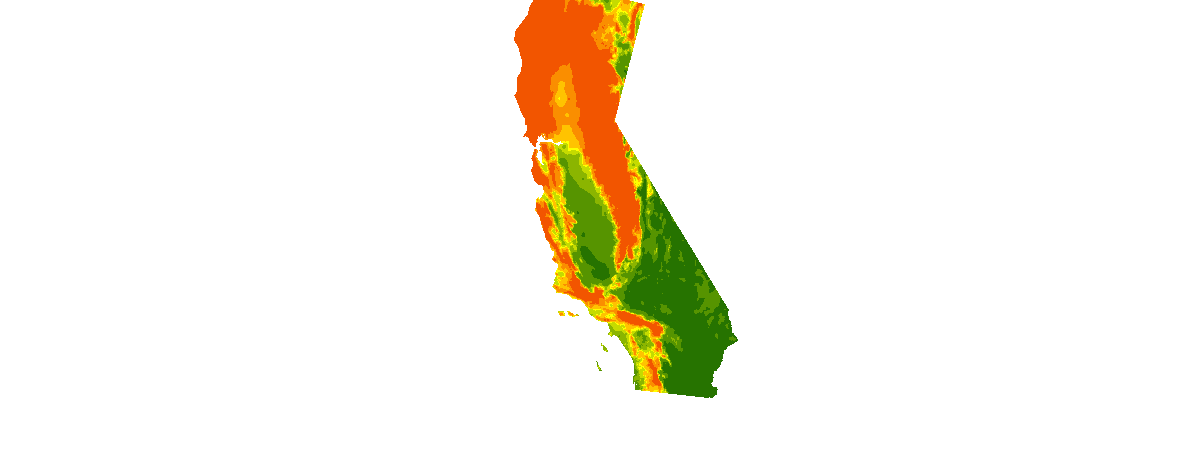

In [67]:
# normalizing rain raster (red indicates high mean rainfall, green indicates low mean rainfall)
rain_input_ranges_n = [24.0, 1000.0, # normalizing 
                      19.5, 24.0,
                      17.0, 19.5, 
                      16.0, 17.0,
                      14.0, 16.0,
                      12.0, 14.0,
                      7.0, 12.0,
                      -100.0, 7.0]
rain_n = remap(raster = rain_clip, # remapping
               input_ranges = rain_input_ranges_n,
               output_values = [7,6,5,4,3,2,1,0],
               astype = 'U8')

rain_n_c = colormap(raster=rain_n, colormap=clrmap8) # visualizing the color map
rain_n_c

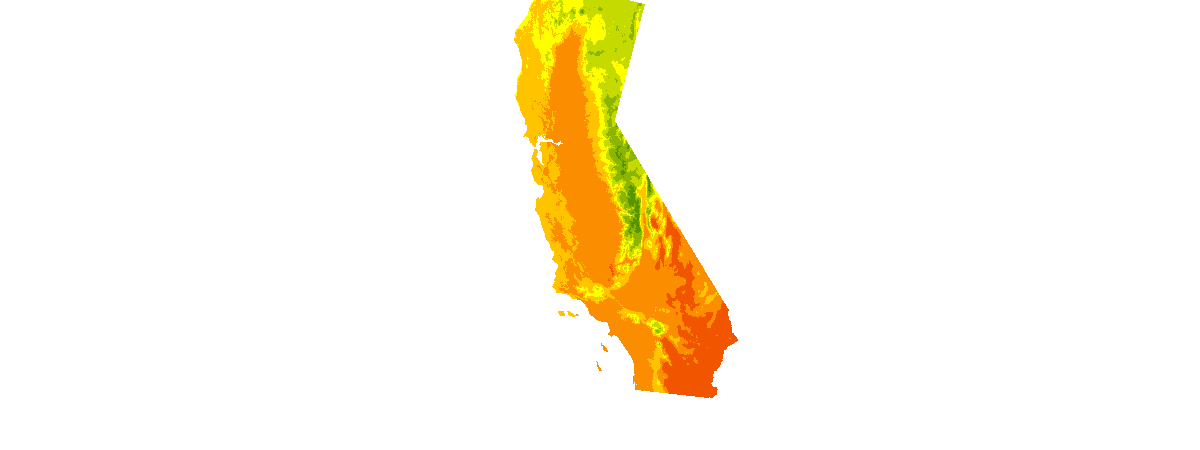

In [68]:
# temperature raster (red indicates high temp, green indicates low temp)
temp_input_ranges_n = [-9, -2, # normalizing 
                      -2, 2,
                      2, 6, 
                      6, 9,
                      9, 12,
                      12, 15,
                      15, 19,
                      19, 32]

temp_n = remap(raster = temp_clip, # remapping
               input_ranges = temp_input_ranges_n,
#                output_values = [8,7,6,5,4,3,2,1],
               output_values = [0,1,2,3,4,5,6,7],
               astype = 'U8')

temp_n_c = colormap(raster=temp_n, colormap=clrmap8) # visualizing the color map
temp_n_c

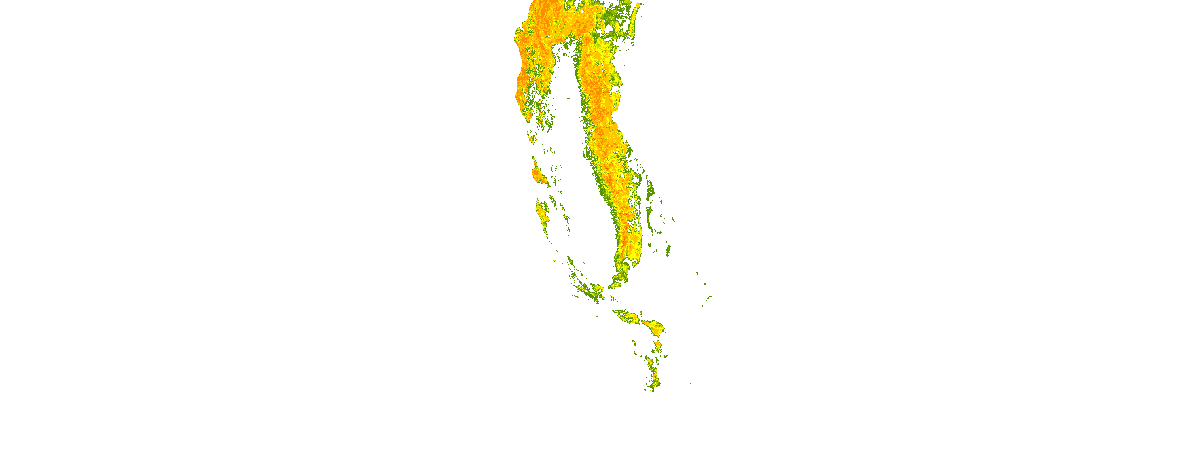

In [69]:
# biomass raster (redder areas indicate higher levels of biomass)
biomass_input_ranges_n = [175, 255, # normalizing 
                      100, 175,
                      50, 100, 
                      30, 50,
                      20, 30,
                      15, 20,
                      10, 15,
                      0, 10]

biomass_n = remap(raster = biomass_clip, # remapping
               input_ranges = biomass_input_ranges_n,
               output_values = [8,7,6,5,4,3,2,1],
               astype = 'U8')

biomass_n_c = colormap(raster=biomass_n, colormap=clrmap8) # visualizing the color map
biomass_n_c

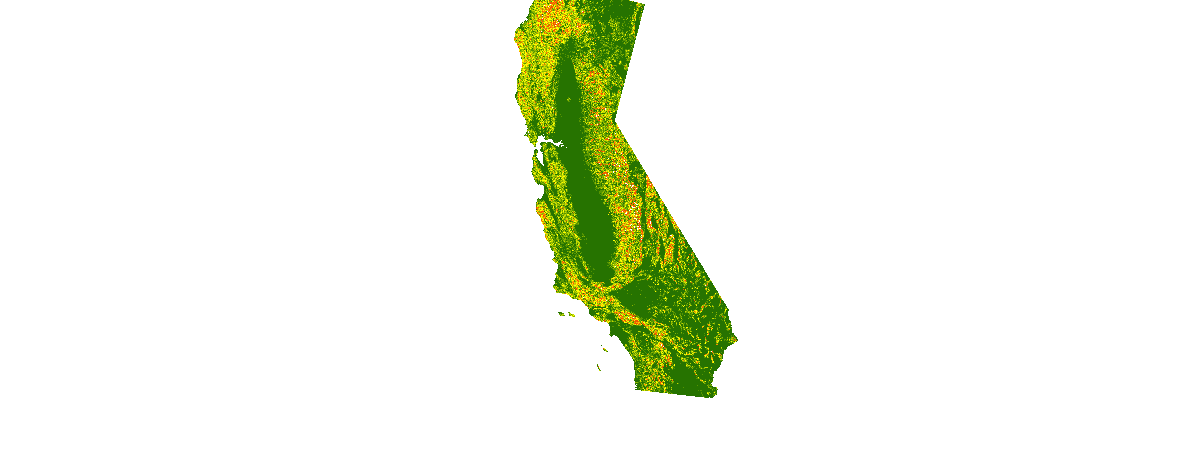

In [70]:
# slope raster (redder areas indicate higher slope)
slope_input_ranges_n = [30.0, 40.0, # normalizing 
                      26.0, 30.0,
                      25.0, 26.0, 
                      20.0, 25.0,
                      15.0, 20.0,
                      10.0, 15.0,
                      5.0, 10.0,
                      0.0, 5.0]

slope_n = remap(raster = slope_clip, # remapping
               input_ranges = slope_input_ranges_n,
               output_values = [7,6,5,4,3,2,1,0],
               astype = 'U8')

slope_n_c = colormap(raster=slope_n, colormap=clrmap8) # visualizing the color map
slope_n_c

### Correlation Analysis - for finding weights of rasters

- In this part, we want to see which of our raster variables correlate the most to fire size, to get a better understanding of how we should rate them when performing the final weighting and rating.

In [71]:
# start with 100 largest fires from our data set
sdf = df.sort_values(by='Shape__Area', ascending=False)
sdf = sdf[:100]

# crate geometries and extents for these 100 largest fires
geoms = [dict(v) for v in sdf.SHAPE.values]
exts = list()

In [72]:
for geom in geoms:
    study_area_ex = geometry.Geometry(geom).geoextent  # or just 'extent'

    # then create the extent as a dict from the returned tuple 
    tup = (('xmin',study_area_ex[0]), ('ymin', study_area_ex[1]), ('xmax',study_area_ex[2]), ('ymax', study_area_ex[3]))
    study_area_extent = dict(tup)
    exts.append(study_area_extent)

In [73]:
# get mean raster values for each extent
mean_rainfalls = list()
mean_biomass = list()
mean_temps = list()
mean_slope = list()
for e in exts:
    try:
        m = usa_mean_rainfall.compute_stats_and_histograms(e)['statistics'][0]['mean']
        mean_rainfalls.append(m)
    except:
        mean_rainfalls.append(np.NaN)
    try:
        m1 = usa_woody_biomass.compute_stats_and_histograms(e)['statistics'][0]['mean']
        mean_biomass.append(m1)
    except:
        mean_biomass.append(np.NaN)
    try:
        m2 = usa_mean_temperature.compute_stats_and_histograms(e)['statistics'][0]['mean']
        mean_temps.append(m2)
    except:
        mean_temps.append(np.NaN) 
    try:
        m3 = usa_slope.compute_stats_and_histograms(e)['statistics'][0]['mean']
        mean_slope.append(m3)
    except:
        mean_slope.append(np.NaN)

In [74]:
sdf['mean_rainfall'] = mean_rainfalls
sdf['mean_biomass'] = mean_biomass
sdf['mean_temps'] = mean_temps
sdf['mean_slope'] = mean_slope
print(sdf.mean_rainfall.isnull().sum())
print(sdf.mean_biomass.isnull().sum())
print(sdf.mean_temps.isnull().sum())
print(sdf.mean_slope.isnull().sum())

0
8
0
0


In [75]:
# find how closely correlated these raster variables are to the area of the largest wildfires
corr, _ = pearsonr(sdf.Shape__Area, sdf.mean_rainfall)
print(corr)
corr, _ = pearsonr(sdf[sdf['mean_biomass'].isnull() == False]['Shape__Area'], sdf[sdf['mean_biomass'].isnull() == False]['mean_biomass'])
print(corr)
corr, _ = pearsonr(sdf.Shape__Area, sdf.mean_temps)
print(corr)
corr, _ = pearsonr(sdf.Shape__Area, sdf.mean_slope)
print(corr)

-0.07756244801253113
-0.15929043347781255
-0.04002654052942213
-0.14385975464618964


In [76]:
# weighting and rating with these slopes: 10 temp, 10 rain, 50 biomass, 30 slope
result1 = (temp_n * .1) + (rain_n * .1) + (biomass_n * .5) + (slope_n * .3)

In [77]:
output = stretch(raster = result1, stretch_type='StdDev', dra='true')

### Find Fire Stations, use this to find underserviced areas

In [127]:
# may have to change title to unique title if running again
published_lyr = gis.content.search(query="Fire_Stations2-shp.zip")[0].publish({"name":"Firestations-PL4"})

In [128]:
# 15 mile drive time buffers around firestations 
buffered = BufferStudyArea(area=published_lyr.layers[0], 
                           radii=[15], units='Minutes', 
                           travel_mode='Driving')

In [80]:
# 15 mile buffers around firestations
eq15 = use_proximity.create_buffers(published_lyr.layers[0], distances=[15], units = 'Miles', dissolve_type = 'Dissolve')
eq15.geom = ca_geom

Now we can make recommendations about what specific locations to target! For remote areas such as the ones highlighted, we will consider inputting preventative measures such as cameras in order to illict an actionable response as soon as a fire in this area appears. For more densely populated areas, we might consider putting a firestation there to add value for both emergency calls as well as wildfires.

Our final analysis ended up differing quite a bit from our initial plan in our proposal. Looking back, our proposed analysis plan seems a bit ambitious given the various constraints we faced throughout this project. The parts of the final version of this project that are similar to our proposal are examining previous wildfire locations, as well as finding weather stations (we ended up using fire stations) around these wildfires. As far places where we deviated from our proposal, there are a few. First, we didn’t end up using geoenrichment to find more information about wildfires, since our initial geoenrichment analysis didn’t end up giving us much useful data. Next, one big theme of our proposal analysis plan was to use a machine learning model to find the features that affect the likelihood of a fire. We didn’t end up doing this, and decided in the end to do outside research (since it was already available) to find important weather features and then combine/aggregate them into a suitability model, and then ultimately finding under serviced areas from there.

## 9. Summary of Results

In [92]:
# final raster mapped
otmap = gis.map('California')
otmap.add_layer(output)
otmap

MapView(layout=Layout(height='400px', width='100%'))

In [93]:
# firestation buffers mapped
map4 = gis.map('California, US', zoomlevel = 6)
map4.add_layer(eq15)
map4

MapView(layout=Layout(height='400px', width='100%'))

In [89]:
# firestation buffers + final raster mapped
map4 = gis.map('California, US', zoomlevel = 6)
map4.add_layer(output)
map4.add_layer(eq15)
map4

MapView(layout=Layout(height='400px', width='100%'))

Here, we see Modoc is higher risk than Klamath, so we might consider measures other than cameras

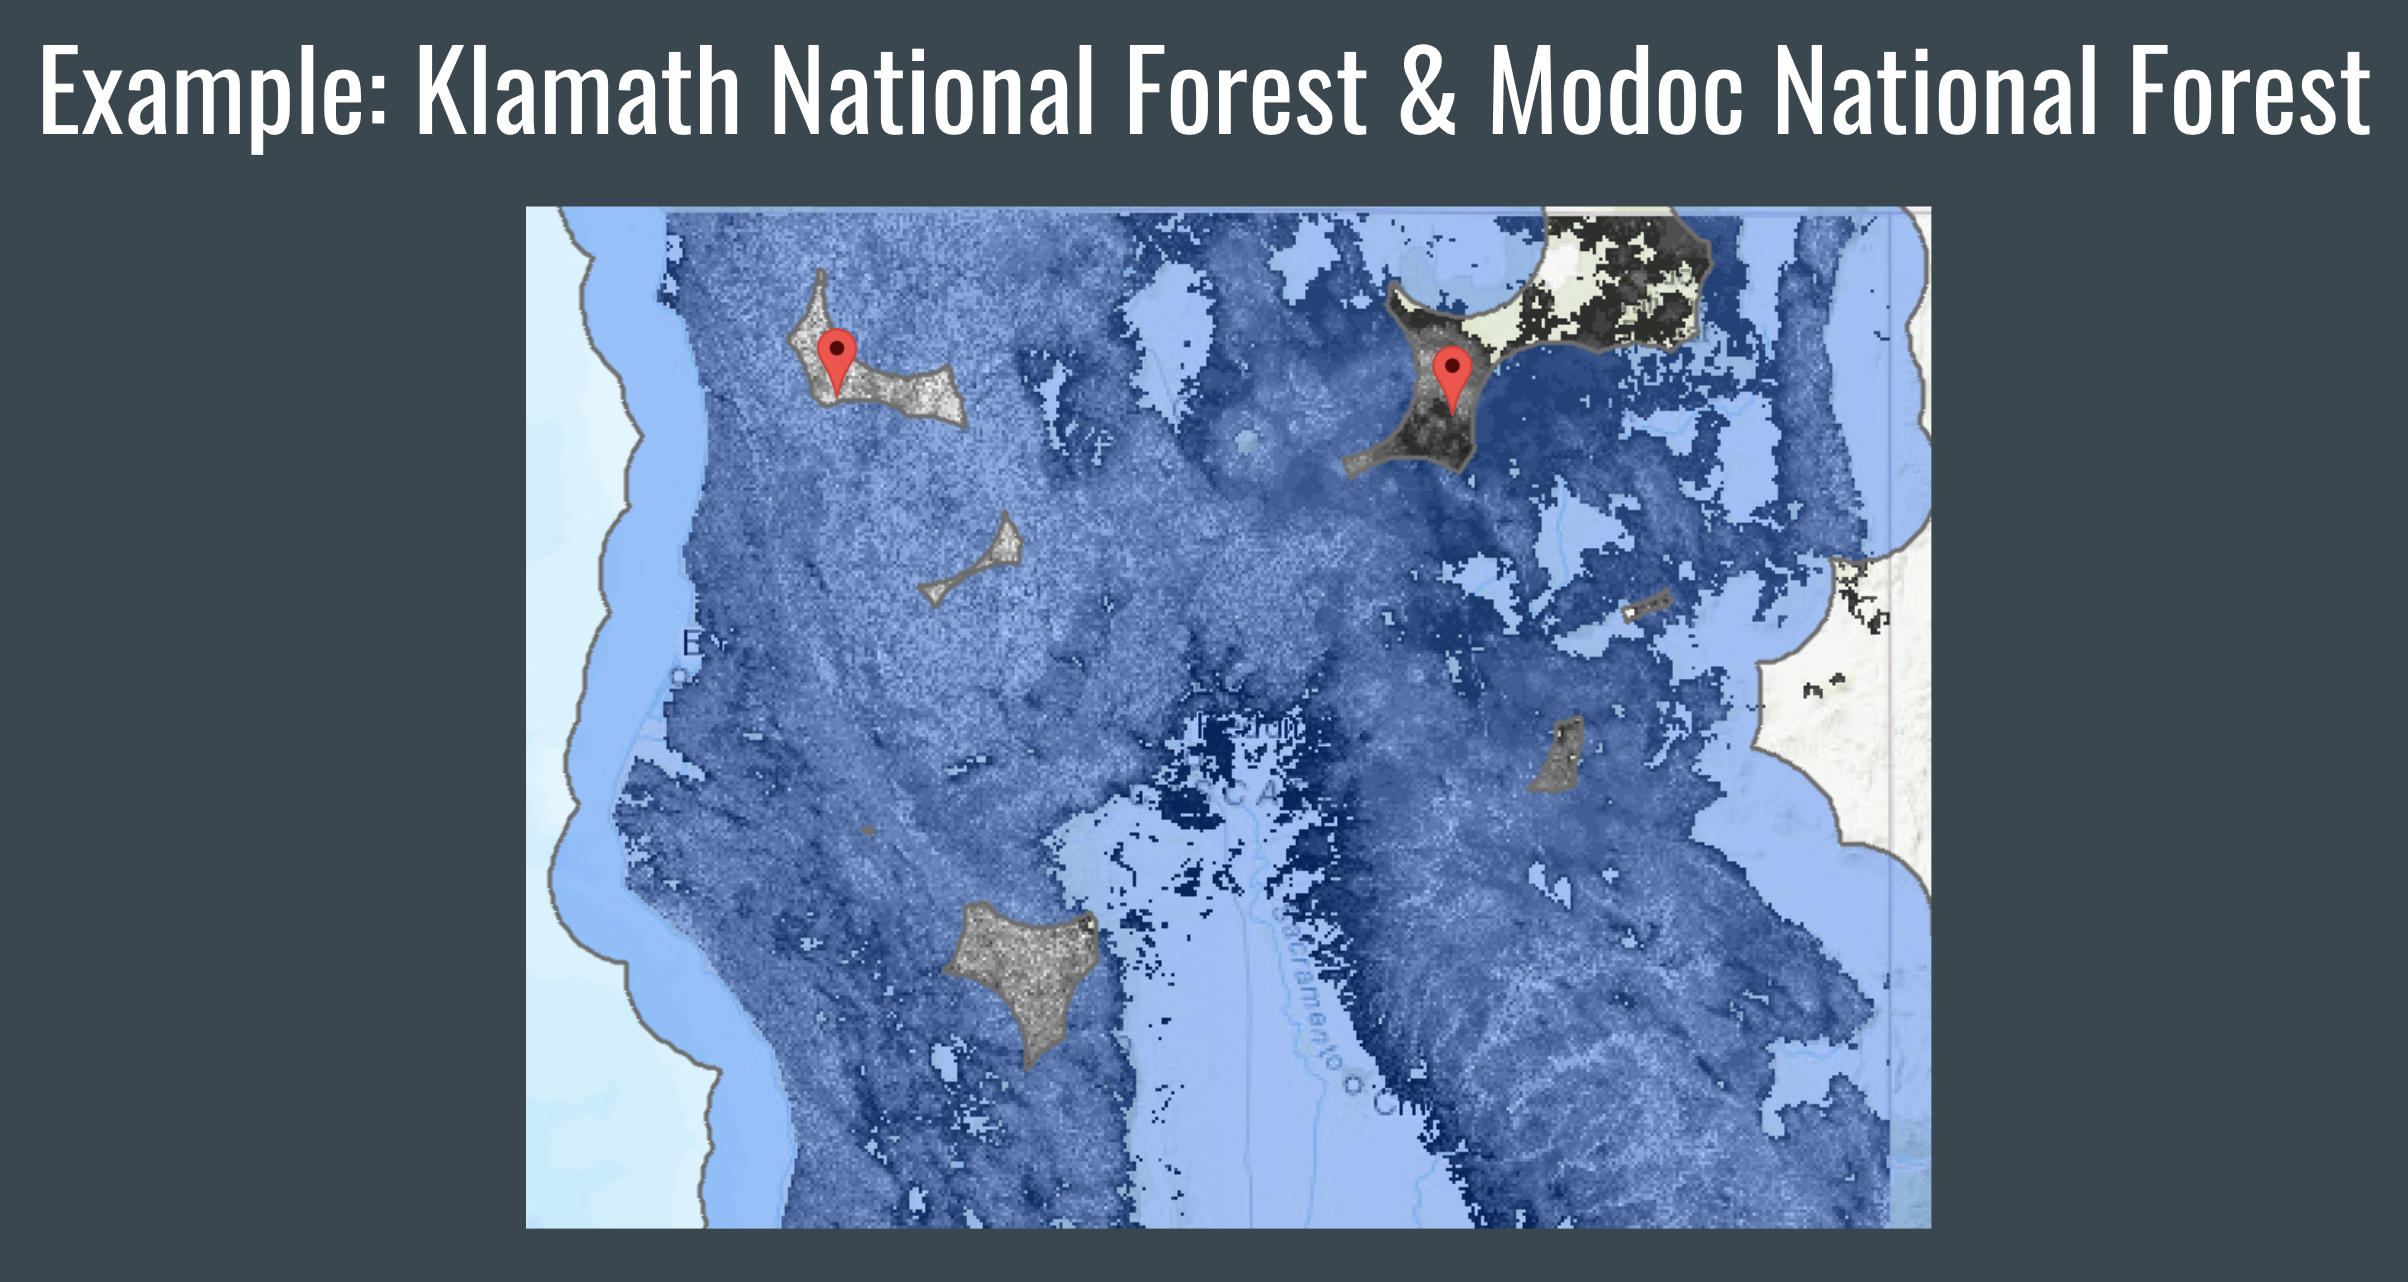

In [84]:
Image(filename = 'HEREHERE.png', width = 800, height = 800)

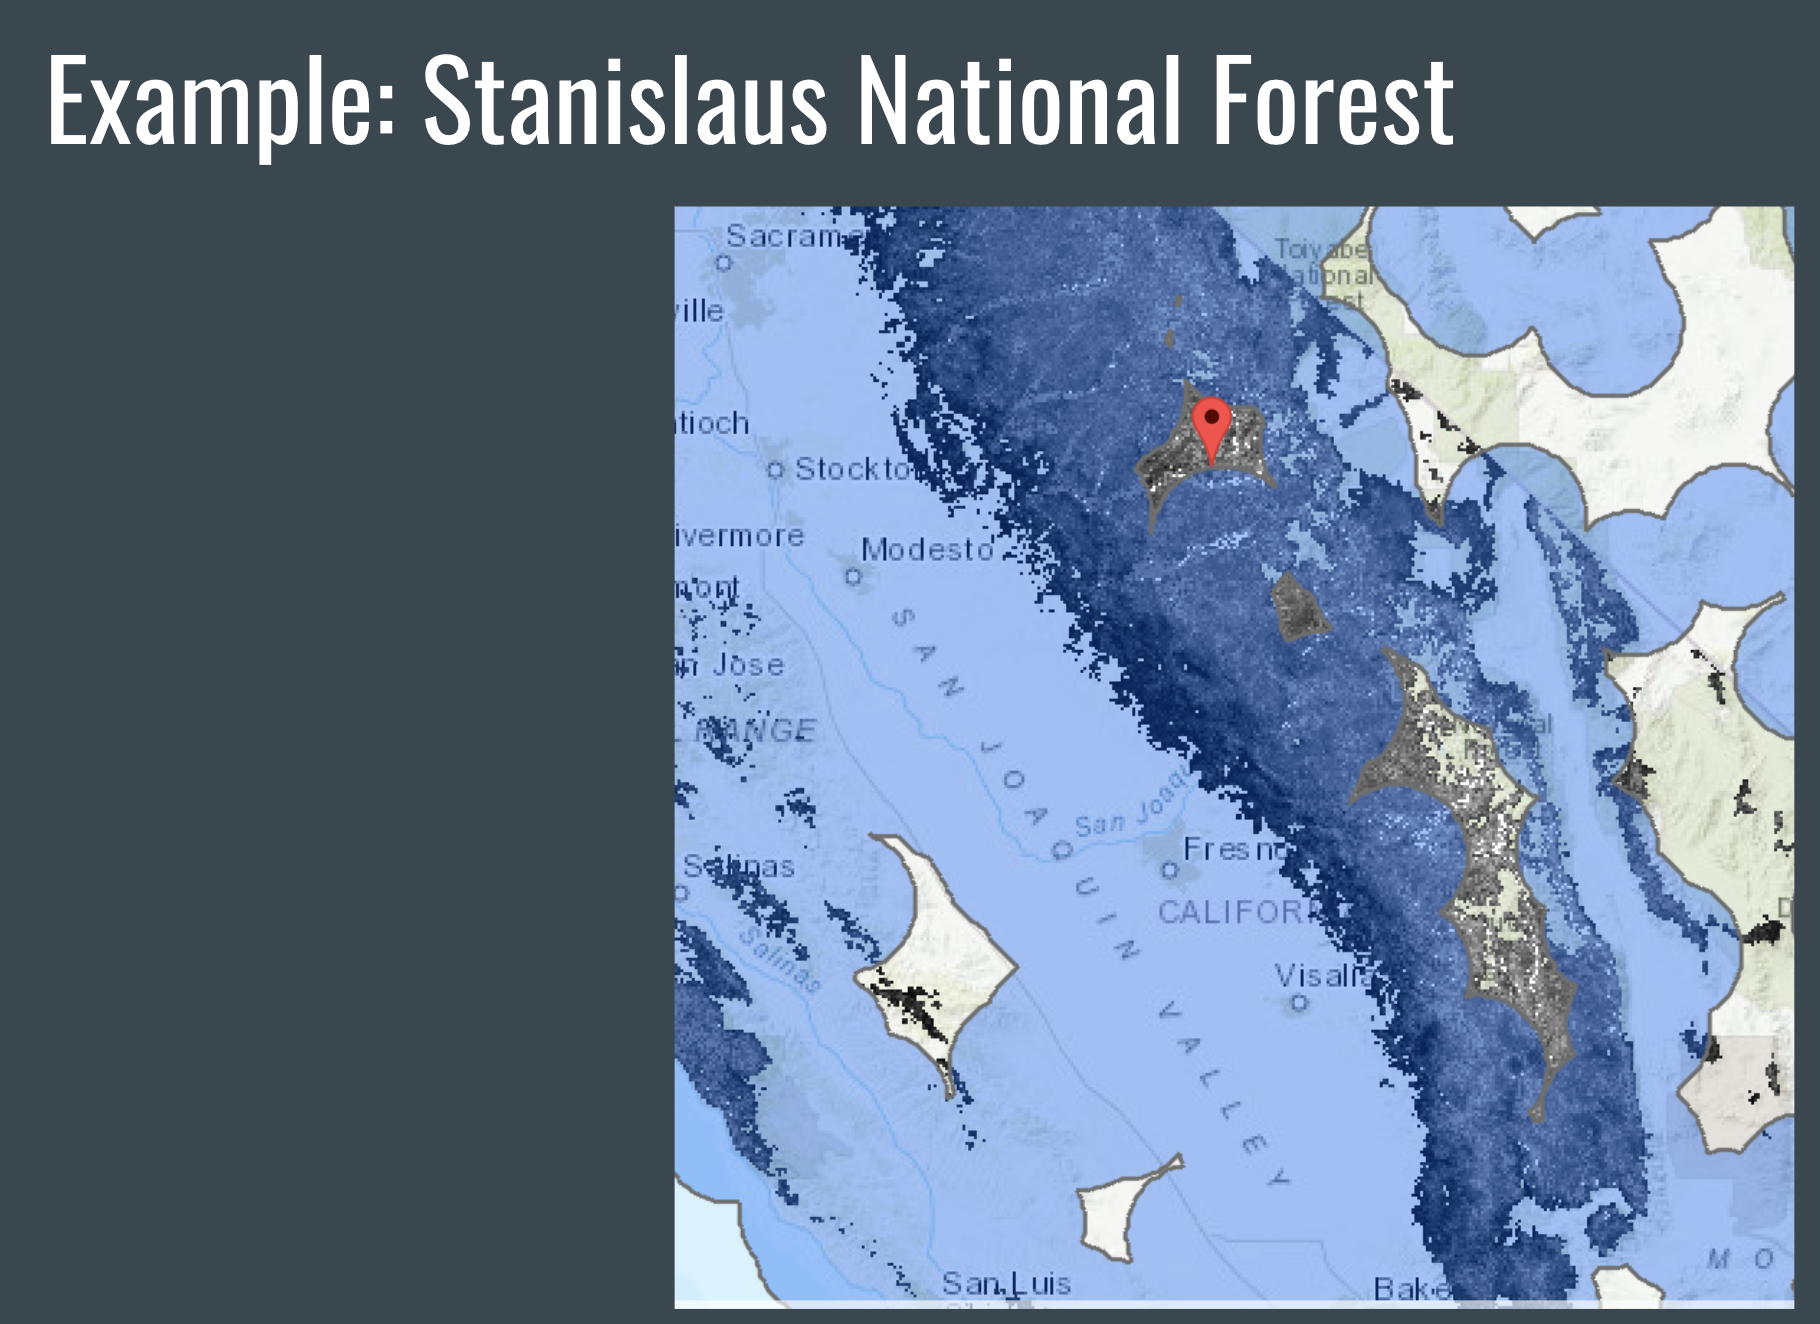

In [85]:
Image(filename = 'HEREHERE2.png', width = 800, height = 800)

Our first result, as seen, is the final raster for our suitability model. This final raster was creating using map combination with the weighting and rating technique, on our established rasters of mean rainfall, mean temperature, biomass, and slope. From what we can see, the highest risk areas for wildfires are the northern-most part of the state along with a strip of land splitting the Sacramento area / San Joaquin Valley and the Sierra Nevada Mountains. There are also smaller patches of land in the southern Bay Area as well as Southern California. This raster is significant because it shows us the highest risk areas for wildfires based on the metrics we outlined earlier.

For our second result, we see where fire stations are located in relation to this wildfire-risk suitability raster. We see that most fire stations end up mirroring population densities, as more populated places are more likely to have more fire stations. This result allows us to have a preliminary sense of how our suitability raster relates to actual fire stations.

Finally, using 15 minute buffers across these fire stations, we can locate 3 under serviced national forests and parks (Klamath National Forest, Modoc National Forest, and Stanislaus National Forest). This is significant because if a wild fire were to occur in these locations (and our suitability model HAS identified them as high-risk locations), being able to mitigate or entirely put out a wildfire would take more time and resources, increasing the likelihood that it does more damage.

## 10. Discussion

Our current results give us insight into weather-based high risk wildfire areas. These results combine insights that were drawn in our sources that explained which weather attributes affect wildfires by aggregating these insights into a larger model, rather than investigating the effect of single weather patterns/phenomena. This model improves the understanding of wildfire risk because it gives researchers, firefighters, and law enforcement officers a framework to detect where wildfires would be the most devastating.

When discussing trade-offs and the main decision-making regarding our analysis, the biggest places we had decisions to make were the rasters we used in our suitability model, the weights of our suitability model and the buffers from fire stations to find underserviced areas. 

For our raster choices, we definitely wanted to use a raster that showed forests and other greenery, since obviously these serve as fuel for wildfires. We also knew that rainfall could be used as an indication for soil moisture, and the assumption we made was that soil moisture would lead to more plants, which also provide more fuel for fires. Next, we wanted to find a raster that indicated humidity, so we used a temperature raster, because temperature generally drives humidity. Finally, from outside research we found that slope can also have an effect on wildfires and wildfire spread, so it was also included in our model.

For our suitability model weights, we went about determining weights in two ways: by trying a correlation analysis and outside research. For our correlation analysis, our R values were very low, so we weren’t able to necessary conclude that the size/intensity of a wildfire particularly depended on one of our raster variables. However, by analyzing these weights, we found that biomass and slope had a higher correlation that rainfall or temperature. Despite this, we didn’t want our weights to solely rely on weights that were very low. Based on our outside research and assumptions we made (discussed earlier), our final weight decisions were:

- rain: 10% - since we really wanted to measure soil moisture, and that we made an assumption that soil moisture leads to more vegetation growth, the weight was relatively low
- temperature: 10% - although we know temperature drives humidity, we found that while humidity does drive growth of vegetation, arid areas also promote wildfire growth; because of this contradiction, the final weight is low
- biomass: 50% - we know that vegetation is the best way for a wildfire to spread, so we weighted this raster the highest
- slope: 30% - from our correlation analysis and outside research we found that slope has a higher effect on wildfires than we initially thought, so the weight for this raster was also higher in comparison to some of the other rasters used

The last decision we had to make was the buffers to create around the fire stations. We found that 15 miles was the best measure because it measured areas that fire stations could service relatively quickly. Therefore, areas that are outside these 15 mile buffers would be areas that fire stations would not be able to get to relatively quickly, and would therefore be under serviced.

## 11. Conclusions and Future Work

In general, we believe we’ve been able to answer our research question, in the sense that we’ve been able to find which factors contribute to wildfires and outline areas of risk based on current resources. However, there are certain datasets and pieces of analysis we were not able to do. Primarily, we wanted to incorporate a wind raster into our suitability model, but weren’t able to find one or convert a shape file correctly due to issues with arcpy/Python compatibility. We also could not supplement further analysis of the raster because we could not convert the raster to shapefile due to acrpy/Python compatibility issues. This severely limited us. Additionally, we wanted to be able to suggest different solutions to address the under serviced areas we found, outside simply building more fire stations (supply depots, cameras, etc). Lastly, we wanted to be able to incorporate population data into our model. Even though we found the highest risk areas to be in the northern parts of the state, from looking at our historical wildfire data we see that, in fact, a majority of the fires happen near highly-populated areas. This aligns with the finding that a majority of wildfires are actually caused by humans.

Although we’ve outlined different ways our results could have been improved, our results can still be used by governmental entities that are involved in the preservation of national forests. By outlining which parks have the highest risk for a wildfire, these managing entities can take certain precautions to either make sure wildfires don’t occur at these locations or establish supply depots or additional resources to put out wildfires if they were to occur in these high-risk areas.
